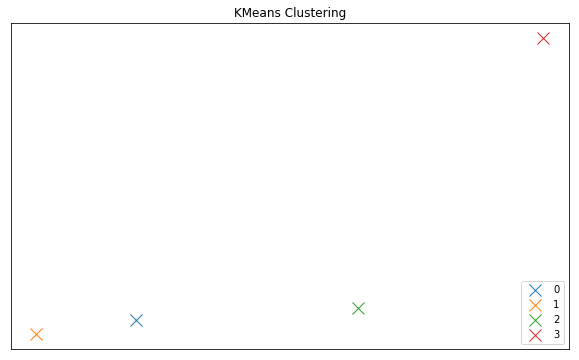

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# df: input dataframe
# df_sample: sampled input dataframe

df = pd.read_csv('consolidated_df_sampled.csv').iloc[:,1:] 
n_rows = 1000

df_sample = df.sample(n = n_rows, random_state = 123, axis = 0)

# Data preprocessing starts here
not_useful = ['Project ID', 'Donation ID','Donor ID',
          'Donor Cart Sequence','Resource Vendor Name','Resource Item Name', 
              'Teacher Project Posted Sequence','School ID', 'Teacher ID',
          'Project Title', 'Project Essay','Project Short Description',
          'Project Need Statement','School Name', 'Donor Zip', 'School Zip']

date_feat = ['Donation Received Date','Project Posted Date', 'Project Expiration Date',
        'Project Fully Funded Date','Teacher First Project Posted Date']

donor_feat = ['Donation ID', 'Donor ID',
       'Donation Included Optional Donation', 'Donation Amount',
       'Donor Cart Sequence', 'Donation Received Date', 
       'Donor City', 'Donor State', 'Donor Is Teacher', 'Donor Zip']

project_feat = ['Resource Item Name',
       'Resource Quantity', 'Resource Unit Price', 'Resource Vendor Name',
       'Project Type', 'Project Title', 'Project Essay',
       'Project Short Description', 'Project Need Statement',
       'Project Subject Category Tree', 'Project Subject Subcategory Tree',
       'Project Grade Level Category', 'Project Resource Category',
       'Project Cost', 'Project Posted Date', 'Project Expiration Date',
       'Project Current Status', 'Project Fully Funded Date', 'Teacher Prefix',
       'Teacher First Project Posted Date', 'School Name', 'School Metro Type',
       'School Percentage Free Lunch', 'School State', 'School Zip',
       'School City', 'School County', 'School District']

cat_feat = ['Donor City', 'Donor State', 'Donor Is Teacher', 'Donor Zip',
            'Project Type','Project Subject Category Tree', 'Donation Included Optional Donation',
            'Project Subject Subcategory Tree',
            'Project Grade Level Category', 'Project Resource Category',
            'Project Current Status','Teacher Prefix','School Metro Type',
            'School State', 'School Zip','School City','School County', 'School District']

# Dropping not so useful data
df_sample = df_sample.drop(labels=not_useful,axis = 1)

#backup
df_backup = df_sample.copy()

# Creating a list of categorical features
cat_feat_new = []
for x in df_sample.columns.tolist(): 
    if x in cat_feat:
        cat_feat_new.append(x)

# Dropping null values
df_sample.dropna(axis=0, inplace=True)


# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder

labels = {}
for cat_feat_new in cat_feat_new:
    le = LabelEncoder()
    le.fit(df_sample[cat_feat_new].value_counts().index.values)
    
    if df_sample[cat_feat_new].dtype == 'float64' or\
    df_sample[cat_feat_new].dtype == 'int':
        df_sample[cat_feat_new] = le.transform(df_sample[cat_feat_new])
    
    else:
        df_sample[cat_feat_new] = le.transform(df_sample[cat_feat_new].astype(str))
    
    labels[cat_feat_new] = list(le.classes_)
    

# Encoding Datetime Variables
    
df_sample['Project Posted Date'] = pd.to_datetime(
    df_sample['Project Posted Date'], errors='coerce')

df_sample['Project Expiration Date'] = pd.to_datetime(
    df_sample['Project Expiration Date'], errors='coerce')

df_sample['Project Fully Funded Date'] = pd.to_datetime(
    df_sample['Project Fully Funded Date'], errors='coerce')

df_sample['Donation Received Date'] = pd.to_datetime(
    df_sample['Donation Received Date'], errors='coerce')

df_sample['Teacher First Project Posted Date'] = pd.to_datetime(
    df_sample['Teacher First Project Posted Date'], errors='coerce')

df_sample['delta-days-before-expiry'] = (df_sample['Project Expiration Date'] - df_sample['Project Posted Date']).dt.days
df_sample['delta-days-before-funded'] = (df_sample['Project Fully Funded Date'] - df_sample['Project Posted Date']).dt.days
df_sample['delta-days-before-donating'] = (df_sample['Donation Received Date'] - df_sample['Project Posted Date']).dt.days


# Identifying Item Profiles by KMeans Clustering starts here
# Assigning feature vectors

X = df_sample[['Resource Quantity', 'Resource Unit Price','Project Type',
       'Project Subject Category Tree', 'Project Subject Subcategory Tree',
       'Project Grade Level Category', 'Project Resource Category',
       'Project Cost', 'Project Current Status', 'Teacher Prefix',
       'School Metro Type','School Percentage Free Lunch', 'School State', 'School City',
       'School County', 'School District']]

# Previously determined optimal number of clusters: 4
n_cluster = 4

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = n_cluster).fit(X)
plt.figure(figsize=(10,6))
for i in range(len(kmeans.cluster_centers_)):
    plt.plot(kmeans.cluster_centers_[i][0],kmeans.cluster_centers_[i][1],'x', markersize=12, label=i);
    plt.xticks([], [])
    plt.yticks([], [])
    plt.legend(loc=4)
plt.title('KMeans Clustering');

# Storing Donor IDs to clusters_list
clusters_list = {}
for c in range(n_cluster):
    clusters_list[c] = df.iloc[X.iloc[kmeans.labels_ == c, :].index]['Donor ID']
 
X['Label'] = kmeans.labels_

# ****************************************************************************
# ****************************************************************************
# ****************************************************************************


# Data preprocessing to store filtered Donor IDs according to cluster

df['Project Posted Date'] = pd.to_datetime(
    df['Project Posted Date'], errors='coerce')

df['Project Expiration Date'] = pd.to_datetime(
    df['Project Expiration Date'], errors='coerce')

df['Project Fully Funded Date'] = pd.to_datetime(
    df['Project Fully Funded Date'], errors='coerce')

df['Donation Received Date'] = pd.to_datetime(
    df['Donation Received Date'], errors='coerce')

df['Teacher First Project Posted Date'] = pd.to_datetime(
    df['Teacher First Project Posted Date'], errors='coerce')

df['delta-days-before-expiry'] = (df['Project Expiration Date'] - df['Project Posted Date']).dt.days
df['delta-days-before-funded'] = (df['Project Fully Funded Date'] - df['Project Posted Date']).dt.days
df['delta-days-before-donating'] = (df['Donation Received Date'] - df['Project Posted Date']).dt.days

# Storing Donor Information per cluster:

clusters_by_state = {}
clusters_by_org_loyalty = {}
clusters_by_early_donors = {}
clusters_by_late_donors = {}
clusters_by_all = {}

for c in range(len(clusters_list)):
    clusters_by_state[c] = df.iloc[clusters_list[c].index][['Donor ID','Donor State']]
    clusters_by_org_loyalty[c] = df.iloc[clusters_list[c].index][['Donor ID','Donation Included Optional Donation']]
    clusters_by_early_donors[c] = df.iloc[clusters_list[c].index][['Donor ID','delta-days-before-donating']][\
    df['delta-days-before-donating']<30]
    clusters_by_late_donors[c] = df.iloc[clusters_list[c].index][['Donor ID','delta-days-before-donating']][\
    df['delta-days-before-donating']>30]
    clusters_by_all[c] = df.iloc[clusters_list[c].index][['Donor ID','Donor State','Donation Included Optional Donation','delta-days-before-donating']]
    
# Filtered Donors are stored in:
# clusters_by_state[c]
# clusters_by_org_loyalty[c]
# clusters_by_early_donors[c]
# clusters_by_late_donors[c]
# where c is the project cluster 

Report:
Max average accuracy: 0.9591
Var of accuracy at optimal parameter: 0.0001
Optimal parameter: 10.0000
Regularization:  l1
1.25 x PCC: 0.5760
Total iterations: 20


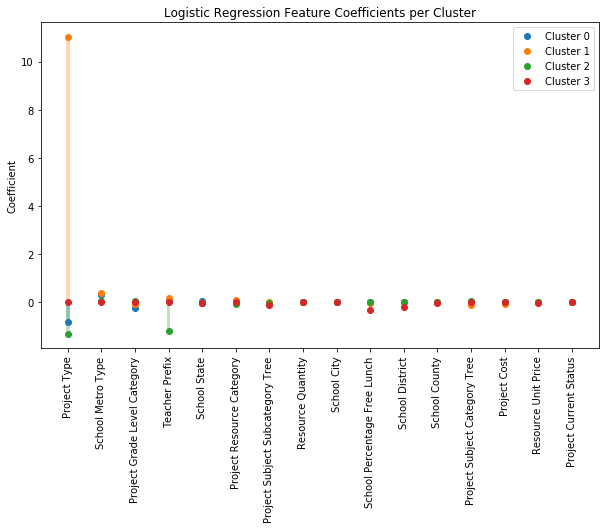

In [2]:
# Classifying Unobserved New Projects starts here
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
pd.options.display.float_format = '{:,.2g}'.format
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Assigning feature and target vectors for classification
X_ = X.drop('Label', axis = 1)
y_ = X['Label']

def ml_class(feature, target, ml_type='knn_class', show_PCC=False,
             param_range=range(1, 30), seed_settings=range(0, 30),
             plot=False, report=True, penalty='l2'):
    """
    Plot accuracy vs parameter for test and training data. Print
    maximum accuracy and corresponding parameter value. Print number of trials.

    Inputs
    ======
    feature: Dataframe of features
    target: Series of target values
    show_PCC: Boolean. will show PCC on plot if True
    param_range: Range of values for parameters
    seed_settings: Range of seed settings to run
    plt: Boolean. Will show plot if True
    report: Boolean. Will show report if True
    penalty: String either l1 for L1 norm or l2 for L2 norm

    Outputs
    =======
    Plot of accuracy vs parameter for test and training data
    Report showing number of maximum accuracy, optimal parameters, PCC, and
        no. of iterations
    """

    train_acc = []
    test_acc = []

    # Initiate counter for number of trials
    iterations = 0

    # create an array of cols: parameters and rows: seeds
    for seed in seed_settings:

        # count one trial
        iterations += 1

        # split data into test and training sets
        X_train, X_test, y_train, y_test = train_test_split(feature,
                                                            target,
                                                            random_state=seed)
        train = []
        test = []

        # make a list of accuracies for different parameters
        for param in param_range:
            # build the model
            if ml_type == 'knn_class':
                clf = KNeighborsClassifier(n_neighbors=param)

            elif ml_type == 'log_reg':
                clf = LogisticRegression(C=param, penalty=penalty)

            elif ml_type == 'svc':
                clf = LinearSVC(C=param, penalty=penalty, dual=False)

            clf.fit(X_train, y_train)

            # record training set accuracy
            train.append(clf.score(X_train, y_train))
            # record generalization accuracy
            test.append(clf.score(X_test, y_test))

        # append the list to _acc arrays
        train_acc.append(train)
        test_acc.append(test)

    # compute mean and error across columns
    train_all = np.mean(train_acc, axis=0)
    test_all = np.mean(test_acc, axis=0)

    # compute standard deviation
    var_train = np.var(train_acc, axis=0)
    var_test = np.var(test_acc, axis=0)

    # compute pcc
    state_counts = Counter(target)
    df_state = pd.DataFrame.from_dict(state_counts, orient='index')
    num = (df_state[0] / df_state[0].sum())**2
    pcc = 1.25 * num.sum()

    if plot == True:
        plt.figure(figsize=(10,6))
        # plot train and errors and standard devs
        plt.plot(param_range, train_all, c='b',
                 label="training set", marker='.')
        plt.fill_between(param_range,
                         train_all + var_train,
                         train_all - var_train,
                         color='b', alpha=0.1)

        # plot test and errors and standard devs
        plt.plot(param_range, test_all, c='r', label="test set", marker='.')
        plt.fill_between(param_range,
                         test_all + var_test,
                         test_all - var_test,
                         color='r', alpha=0.1)

        # plot pcc line
        if show_PCC == True:
            plt.plot(param_range, [pcc] * len(param_range),
                     c='tab:gray', label="pcc", linestyle='--')

        plt.xlabel('Parameter Value')
        plt.ylabel('Accuracy')
        plt.title(ml_type + ": Accuracy vs Parameter Value")
        plt.legend(loc=0)

        plt.tight_layout()
        plt.show()

    max_inds = np.argmax(test_all)
    acc_max = np.amax(test_all)
    param_max = (param_range)[max_inds]

    if report == True:
        print('Report:')
        print('=======')
        print("Max average accuracy: {}".format(
            np.round(acc_max, 4)))
        print("Var of accuracy at optimal parameter: {0:.4f}".format(
            var_test[max_inds]))
        print("Optimal parameter: {0:.4f}".format(param_max))
        if ml_type != "knn_class":
            print("Regularization: ", penalty)
        print('1.25 x PCC: {0:.4f}'.format(pcc))
        print('Total iterations: {}'.format(iterations))
        

    # return maximum accuracy and corresponding parameter value
    return np.round(acc_max, 4), param_max  # best_feat


# Finding optimal parameters for logistic regression classifier
C = [1e-3,0.1, 0.2,0.4, 0.75, 1, 5, 10, 15, 20, 100]

acc_max, param_max = ml_class(X_, y_, ml_type='log_reg', show_PCC=False,
                            param_range=C, seed_settings=range(0, 20),
                            plot=False, report=True, penalty='l1');

# Plotting logistic regression
X_train, X_test, y_train, y_test = train_test_split(X_, y_)
clf = LogisticRegression(C=param_max, penalty='l1')
clf.fit(X_train, y_train)

plt.figure(figsize=(10,6))
for i in range(n_cluster):
    sorted_i = np.argsort(abs(clf.coef_[i]))[::-1]
    
    plt.plot(X_.columns[sorted_i], clf.coef_[i][sorted_i], marker='o', linestyle='none', linewidth=1, label = "Cluster "+str(i))
    plt.bar(X_.columns[sorted_i], clf.coef_[i][sorted_i], alpha=0.3, width=0.1)
    plt.legend()
    plt.xticks(rotation=90)
    plt.ylabel("Coefficient")
    plt.title("Logistic Regression Feature Coefficients per Cluster")
plt.show()

In [3]:
import pandas as pd
X_test = pd.DataFrame(columns=['Resource Quantity', 'Resource Unit Price','Project Type',
       'Project Subject Category Tree', 'Project Subject Subcategory Tree',
       'Project Grade Level Category', 'Project Resource Category',
       'Project Cost', 'Project Current Status', 'Teacher Prefix',
       'School Metro Type','School Percentage Free Lunch', 'School State', 'School City',
       'School County', 'School District'])

In [4]:
X_test['Resource Quantity'] = [10]
X_test['Resource Unit Price'] = [10]
X_test['Project Type'] = ['Teacher-Led']
X_test['Project Subject Category Tree'] = ['Health & Sports']
X_test['Project Subject Subcategory Tree'] = ['Gym & Fitness, Health & Wellness']
X_test['Project Grade Level Category'] = ['Grades 9-12']
X_test['Project Resource Category'] = ['Sports & Exercise Equipment']
X_test['Project Cost'] = [53.3]
X_test['Project Current Status'] = ['Fully Funded']
X_test['Teacher Prefix'] = ['Mrs.']
X_test['School Metro Type'] = ['suburban']
X_test['School Percentage Free Lunch'] = [65]
X_test['School State'] = ['New York']
X_test['School City'] = ['New York City']
X_test['School County'] = ['Queens']
X_test['School District'] = ['New York Dept Of Education']

In [5]:
def donors_to_recommend(X, index = 0, cluster_disp = False):
    project_type = []
    project_subject_cat = []
    project_subject_subcat = []
    project_grade_level_cat = [] 
    project_resource_cat = [] 
    project_current_stat = []
    teacher_pref = []
    school_metro = []
    school_state = []
    school_city = []
    school_county = []
    school_district = []

    for i in range(len(X_test)):
        project_type.append(labels['Project Type'].index(X_test['Project Type'][i]))
        project_subject_cat.append(labels['Project Subject Category Tree'].index(X_test['Project Subject Category Tree'][i]))
        project_subject_subcat.append(labels['Project Subject Subcategory Tree'].index(X_test['Project Subject Subcategory Tree'][i]))      
        project_grade_level_cat.append(labels['Project Grade Level Category'].index(X_test['Project Grade Level Category'][i]))
        project_resource_cat.append(labels['Project Resource Category'].index(X_test['Project Resource Category'][i]))  
        project_current_stat.append(labels['Project Current Status'].index(X_test['Project Current Status'][i])) 
        teacher_pref.append(labels['Teacher Prefix'].index(X_test['Teacher Prefix'][i]))
        school_metro.append(labels['School Metro Type'].index(X_test['School Metro Type'][i]))
        school_state.append(labels['School State'].index(X_test['School State'][i]))
        school_city.append(labels['School City'].index(X_test['School City'][i]))
        school_county.append(labels['School County'].index(X_test['School County'][i]))
        school_district.append(labels['School District'].index(X_test['School District'][i]))
    
    X_test_transformed = pd.DataFrame(columns=['Resource Quantity', 'Resource Unit Price','Project Type',
       'Project Subject Category Tree', 'Project Subject Subcategory Tree',
       'Project Grade Level Category', 'Project Resource Category',
       'Project Cost', 'Project Current Status', 'Teacher Prefix',
       'School Metro Type','School Percentage Free Lunch', 'School State', 'School City',
       'School County', 'School District'])

    X_test_transformed['Resource Quantity'] = X_test['Resource Quantity']
    X_test_transformed['Resource Unit Price'] = X_test['Resource Unit Price']
    X_test_transformed['Project Type'] = project_type
    X_test_transformed['Project Subject Category Tree'] = project_subject_cat
    X_test_transformed['Project Subject Subcategory Tree'] = project_subject_subcat
    X_test_transformed['Project Grade Level Category'] = project_grade_level_cat
    X_test_transformed['Project Resource Category'] = project_resource_cat
    X_test_transformed['Project Cost'] = X_test['Project Cost']
    X_test_transformed['Project Current Status'] = project_current_stat
    X_test_transformed['Teacher Prefix'] = teacher_pref
    X_test_transformed['School Metro Type'] = school_metro
    X_test_transformed['School Percentage Free Lunch'] = X_test['School Percentage Free Lunch']
    X_test_transformed['School State'] = school_state
    X_test_transformed['School City'] = school_city
    X_test_transformed['School County'] = school_county
    X_test_transformed['School District'] = school_district
    

    
    y = clf.predict(X_test_transformed)
    
    if cluster_disp == True:
        print(y[index])
    else:
        pass
    
    return clusters_by_all[y[index]]
                 

In [6]:
# y
# clusters_by_all

In [7]:
donors_to_recommend(X_test, index = 0, cluster_disp = False).head()

,Donor ID,Donor State,Donation Included Optional Donation,delta-days-before-donating
42083,794d7b0af5fbff40e6902537f628e466,Indiana,Yes,25
99535,15e8f0dcf8c36fa2f786c741f81bab53,New Jersey,Yes,4
47879,413e2b1a73beef60d0f370bc44403592,California,No,0
36734,73a51b046a3208407d1290a0ab8f7e4f,Wisconsin,Yes,1.2e+02
44826,7bd89b230404c656f3451ae445b3c0da,Florida,Yes,15


In [8]:
import pickle

In [9]:
# %%time
# pickle_out = open("model.pickle","wb")
# pickle.dump(clf, pickle_out)
# pickle_out.close()

In [10]:
# %%time
# pickle_out = open("clusters.pickle","wb")
# pickle.dump(clusters_by_all, pickle_out)
# pickle_out.close()

In [11]:
# %%time
# pickle_out = open("labels.pickle","wb")
# pickle.dump(labels, pickle_out)
# pickle_out.close()

In [12]:
out = donors_to_recommend(X_test, index = 0, cluster_disp = False)['Donor ID']
out.tolist()

['794d7b0af5fbff40e6902537f628e466',
 '15e8f0dcf8c36fa2f786c741f81bab53',
 '413e2b1a73beef60d0f370bc44403592',
 '73a51b046a3208407d1290a0ab8f7e4f',
 '7bd89b230404c656f3451ae445b3c0da',
 'b1792f3296d692a5e831fbd26d3bb16e',
 '3fa50256e13a04822fd7b6c8c756ac92',
 '8992e625bd023b8705b015fd548952ec',
 '989fde594c631ee666df158e4e604012',
 'd4442f16aa65263c3b59d2c76491399e',
 'd685889049026eadfc4238fd98fbeeab',
 'a076f9be8f23990619d7da05571b127e',
 '37707fc83eb90bb94fd973da5a296f08',
 'a0597a34e3790cb99cfb63e5e8d0a26d',
 'c4224a0a369a12a2965b2b49ca0e9c33',
 '2d4f13ba7f59033c95fabceee12ee8cb',
 '442f31b075fa123e61f4a33246c8d41c',
 'e75bbbb63eae63833845a2ccc46999b7',
 '79088122eeede81d75cc653da34a6c8d',
 'b244e63e367df8983fda3c8448145bc2',
 '84357490d0aeb3711ae4d1462fb51d01',
 '035ca2837d5ddd93fc93c6c14f9836e6',
 'f1cd28acb8da5abc0de4d61867da0261',
 '525a20af76b3c205f64ee6781a2dc746',
 '259bd4421aa306b91c0f8cdf3cb853f6',
 '29d7465e70328fe541421f9ff33110f0',
 '4ec667fce6dd9b152718853f6d6ee255',
 

In [27]:
# X_.dtypes

In [28]:
# df_sample.head()

In [29]:
# cat_feat_new

In [16]:
df_backup.head()

,Donation Included Optional Donation,Donation Amount,Donation Received Date,Resource Quantity,Resource Unit Price,Donor City,Donor State,Donor Is Teacher,Project Type,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Current Status,Project Fully Funded Date,Teacher Prefix,Teacher First Project Posted Date,School Metro Type,School Percentage Free Lunch,School State,School City,School County,School District
42083,Yes,50,2017-08-23 13:51:41,1,8.4,Lafayette,Indiana,No,Teacher-Led,Literacy & Language,"Literacy, Literature & Writing",Grades PreK-2,Books,5.3e+02,2017-07-29,2017-11-28,Fully Funded,2017-08-23,Mrs.,2012-04-14,urban,19,Indiana,W Lafayette,Tippecanoe,West Lafayette Cmty Sch Dist
71825,Yes,50,2016-10-18 16:22:46,1,1.9e+02,Chicago,Illinois,No,Teacher-Led,"Applied Learning, Literacy & Language","College & Career Prep, Literacy",Grades 6-8,Technology,2.5e+03,2016-07-11,2016-11-10,Fully Funded,2016-11-08,Ms.,2016-07-11,urban,84,California,Oakland,Alameda,Oakland Unified School Dist
99535,Yes,2.3e+02,2015-12-31 17:42:21,1,9.5,Cresskill,New Jersey,No,Teacher-Led,Literacy & Language,"Literacy, Literature & Writing",Grades 3-5,Books,5.3e+02,2015-12-27,2016-04-26,Fully Funded,2015-12-31,Mrs.,2015-12-27,suburban,69,North Carolina,Conover,Catawba,Catawba Co School District
47879,No,25,2017-08-18 18:40:15,1,12,Alameda,California,Yes,Teacher-Led,"Literacy & Language, History & Civics","Literacy, Social Sciences",Grades 3-5,Books,4.2e+02,2017-08-18,2017-12-18,Fully Funded,2017-08-18,Ms.,2017-08-18,urban,62,California,San Leandro,Alameda,San Lorenzo Unified Sch Dist
36734,Yes,1.5e+02,2017-12-16 09:33:49,5,14,Madison,Wisconsin,No,Teacher-Led,"Literacy & Language, Math & Science","Literacy, Mathematics",Grades PreK-2,Technology,5.9e+02,2017-08-23,2017-12-23,Fully Funded,2017-12-16,Mrs.,2017-08-23,suburban,69,Wisconsin,Kenosha,Kenosha,Kenosha Unified School Dist 1


In [25]:
cols_backup = ['Resource Quantity', 'Resource Unit Price','Project Type',
       'Project Subject Category Tree', 'Project Subject Subcategory Tree',
       'Project Grade Level Category', 'Project Resource Category',
       'Project Cost', 'Project Current Status', 'Teacher Prefix',
       'School Metro Type','School Percentage Free Lunch', 'School State', 'School City',
       'School County', 'School District']

cats_backup = {}
for idx, c in enumerate(cols_backup):
    if idx in [0,1,7,11]:
        cats_backup[idx] = []
    else:
        cats_backup[idx] = df_backup[c].value_counts().index.tolist()

In [33]:
# df_backup[cols_backup[0]]
# cats_backup
for c in cats_backup:
    #print(c)
    if not cats_backup[c]:
        print(c)

0
1
7
11


In [34]:
pickle_out = open("categories.pickle","wb")
pickle.dump(cats_backup, pickle_out)
pickle_out.close()